Welcome back to week three of [Regression Modelling in Practice](https://www.coursera.org/learn/regression-modeling-practice/home/welcome)! I'm writing this step in the **Breast Cancer Causes Internet Usage!** (BCCIU) [project](http://lilithelina.tumblr.com/post/128347327089/choice-of-data) in two parts:
- [The first part](http://lilithelina.tumblr.com/post/147984528439/multiple-linear-regression-python) applied a multiple regression model to analyse the association of one of my response variables (internet users per 100 people in 2010) with my primary explanatory variable (new breast cancer cases per 100,000 females in 2002) and additional variables (my previously used [moderator](http://lilithelina.tumblr.com/post/143790528809/data-analysis-moderators-python) income per person in 2010, and the percentage of urban populations in 2008). This was also the part of the project to be graded on [coursera](https://www.coursera.org/).
- The second part (which is this) will make use of another modelling technique we learned about this week: [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression). This will allow me to better analyse the association between my second response variable (percentage of employed females in 2007) with breast cancer as explanatory variable, since I've already seen that [linear regression](http://lilithelina.tumblr.com/post/147586176199/basic-linear-regression-r) doesn't work on these data.

As before, the output will look lots better in the [nbviewer](http://nbviewer.ipython.org/github/LilithElina/Data-Analysis-and-Interpretation/tree/master/RegModPrac/Week%20Three%20-%20Polynomial%20Regression.ipynb) than on tumblr.

First up comes the code to prepare the raw data, filtering for the country identifiers, breast cancer, and female employment rates.

In [1]:
# activate inline plotting, should be first statement
%matplotlib inline

# load packages
import warnings                     # ignore warnings (e.g. from future, deprecation, etc.)
warnings.filterwarnings('ignore')   # for layout reasons, after I read and acknowledged them all!

import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# read in data
data = pandas.read_csv("../gapminder.csv", low_memory=False)

# subset the data and make a copy to avoid error messages later on
sub = data[["breastcancerper100th", "femaleemployrate"]]
sub_data = sub.copy()

# change data types to numeric
sub_data["breastcancerper100th"] = pandas.to_numeric(sub_data["breastcancerper100th"], errors="coerce")
sub_data["femaleemployrate"] = pandas.to_numeric(sub_data["femaleemployrate"], errors="coerce")

# remove rows with missing values (copy again)
sub2 = sub_data.dropna()
sub_data2 = sub2.copy()

As the explanatory variable, breast cancer prevalence should be mean centred for easier interpretation. To do this, I have to subtract the variable mean from every single observation.

In [2]:
# take breast cancer case column and subtract mean
sub_data2[["breastCentred"]] = sub_data2[["breastcancerper100th"]] - sub_data2[["breastcancerper100th"]].mean()

# examine data summary
print("data after centring")
print(sub_data2.describe())

data after centring
       breastcancerper100th  femaleemployrate  breastCentred
count            168.000000        168.000000   1.680000e+02
mean              37.550000         47.845238  -1.818651e-14
std               22.944904         14.696742   2.294490e+01
min                3.900000         12.400000  -3.365000e+01
25%               20.550000         39.100000  -1.700000e+01
50%               29.900000         48.200001  -7.650000e+00
75%               50.325000         56.050000   1.277500e+01
max              101.100000         83.300003   6.355000e+01


The `describe()` function again does not return a mean equal to zero for the centred variable, but the value is close to zero. This is a problem of float representation common in Python, as explained in the [Python tutorial](https://docs.python.org/3/tutorial/floatingpoint.html).

I'll start again with the [basic linear model](http://lilithelina.tumblr.com/post/147441369709/basic-linear-regression-python) so that I can compare this to the polynomial regression model.

In [3]:
# regression model for breast cancer and female employment
print ("OLS regression model for the association between breast cancer cases and female employment rate")
reg1 = smf.ols("femaleemployrate ~ breastCentred", data=sub_data2).fit()
print (reg1.summary())

OLS regression model for the association between breast cancer cases and female employment rate
                            OLS Regression Results                            
Dep. Variable:       femaleemployrate   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9456
Date:                Tue, 09 Aug 2016   Prob (F-statistic):              0.332
Time:                        17:14:25   Log-Likelihood:                -688.92
No. Observations:                 168   AIC:                             1382.
Df Residuals:                     166   BIC:                             1388.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------

For the association of female employment rates and breast cancer cases per 100,000 people, the $r²$ value (or the "coefficient of correlation") at the top right of the OLS regression results is $0.006$. This means that the variability in occurrence of new breast cancer cases can explain only 0.6% of the variability in the female unemployment rates based on linear regression.

Below this first part of the results, parameter estimates are presented for either the intercept (female employment) or breast cancer cases. The coefficient for breast cancer is negative, meaning that there might be a negative association between breast cancer and female employment. The high *p*-value and the confidence intervals encompassing zero indicate that this result is not statistically significant, though, and we shouldn't speak of an association here.

This can also be demonstrated in a scatterplot with the associated regression line.

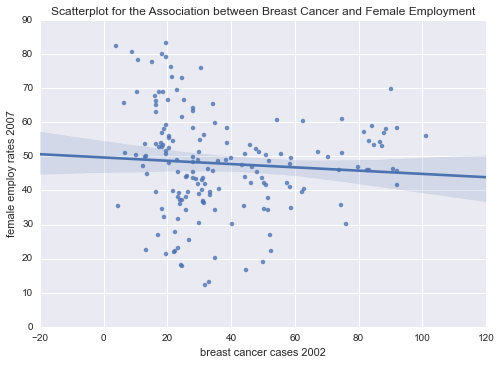

In [4]:
# plot bivariate scatterplot
seaborn.regplot(x="breastcancerper100th", y="femaleemployrate", fit_reg=True, data=sub_data2);
plt.xlabel('breast cancer cases 2002');
plt.ylabel('female employ rates 2007');
plt.title('Scatterplot for the Association between Breast Cancer and Female Employment');

Since the data points show a slightly curved distribution, it would make sense to use a second order polynomial regression instead. It looks like this:

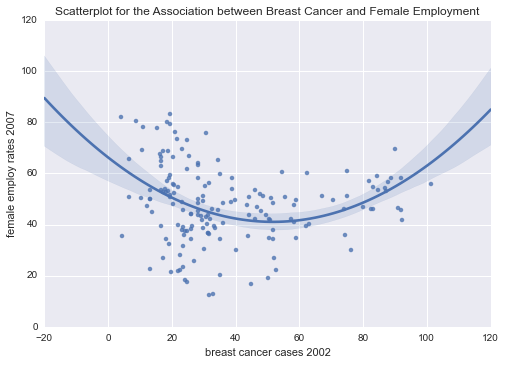

In [5]:
# fit second order polynomial
seaborn.regplot(x="breastcancerper100th", y="femaleemployrate", scatter=True, order=2, data=sub_data2)
plt.xlabel('breast cancer cases 2002');
plt.ylabel('female employ rates 2007');
plt.title('Scatterplot for the Association between Breast Cancer and Female Employment');

This looks better, doesn't it? I can run the regression analysis for this by including a new term in the formula: `I(breastCentred**2)`. The `I()` here is the so called *Identity* function from a package called [patsy](http://patsy.readthedocs.io/en/latest/overview.html) (based on a Monty Python movie character). This function returns its input unchanged, enabling me to add a term for my squared explanatory variable. Without this function, Python would use the `**2` as part of the model, instead of as a transformation only for that one variable.

In [6]:
# polynomial regression model for breast cancer and female employment
print ("OLS polynomial regression model for the association between breast cancer cases and female employment rate")
reg2 = smf.ols("femaleemployrate ~ breastCentred + I(breastCentred**2)", data=sub_data2).fit()
print (reg2.summary())

OLS polynomial regression model for the association between breast cancer cases and female employment rate
                            OLS Regression Results                            
Dep. Variable:       femaleemployrate   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     11.64
Date:                Tue, 09 Aug 2016   Prob (F-statistic):           1.87e-05
Time:                        17:16:22   Log-Likelihood:                -678.32
No. Observations:                 168   AIC:                             1363.
Df Residuals:                     165   BIC:                             1372.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------

The model is still far from perfect, but definitely better than before. The $r²$ value is now $0.124$, which means that the variability in the explanatory variable (breast cancer cases) can explain 12% of the variability of the response variable (female employment). Additionally, the negative coefficient for the explanatory variable is even lower than before, and now comes with a low *p*-value and an all-negative 95% confidence interval as well, so this is a statistically significant negative association. The coefficient for the quadratic term, on the other hand, is positive, and this association is also significant. This means that there is indeed some curvature in the data, seen here as a convex shape - starting high, then going down before rising again. The still relatively low $r²$ (compared to $0.625$ for [breast cancer and internet usage](http://lilithelina.tumblr.com/post/147984528439/multiple-linear-regression-python)) lets me believe that I could do better with a different model, but this should suffice for now.

At the bottom of the results there is again a warning about strong multicollinearity, which I've also seen in the previous post about [multiple regression](http://lilithelina.tumblr.com/post/147984528439/multiple-linear-regression-python). In this case, this is definitely expected, since I've only added a variable that's already in the model, only this time it's squared. Of course the squared variable is correlated to the original, and there's nothing more that can be done about that. Apparently, centring the explanatory variable reduces the correlation between linear and quadratic variables, and that I have already done.